# Counterfactual explanations with one-hot encoded categorical variables

Real world machine learning applications often handle data with categorical variables. Explanation methods which rely on perturbations of the input features need to make sure those perturbations are meaningful and capture the underlying structure of the data. This becomes tricky for categorical features. For instance random perturbations across possible categories or enforcing a ranking between categories based on frequency of occurrence in the training data do not capture this structure. Our method captures the relation between categories of a variable numerically through the context given by the other features in the data and/or the predictions made by the model. First it captures the pairwise distances between categories and then applies multi-dimensional scaling. More details about the method can be found in the [documentation](https://docs.seldon.io/projects/alibi/en/stable/methods/CFProto.html). The example notebook illustrates this approach on the *adult* dataset, which contains a mixture of categorical and numerical features used to predict whether a person's income is above or below $50k.

<div class="alert alert-info">
Note
    
To enable support for CounterfactualProto, you may need to run
    
```bash
pip install alibi[tensorflow]
```

</div>

In [1]:
import tensorflow as tf
tf.get_logger().setLevel(40) # suppress deprecation messages
#tf.compat.v1.disable_v2_behavior() # disable TF2 behaviour as alibi code still relies on TF1 constructs
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.preprocessing import OneHotEncoder
from time import time
from alibi.datasets import fetch_adult
from alibi.explainers import CounterfactualProto
from alibi.utils import ohe_to_ord, ord_to_ohe

print('TF version: ', tf.__version__)
print('Eager execution enabled: ', tf.executing_eagerly()) # False

TF version:  2.12.1
Eager execution enabled:  True


In [2]:
import os
import numpy as np
import pandas as pd
from copy import deepcopy
from typing import List, Tuple, Dict, Callable

import tensorflow as tf
import tensorflow.keras as keras

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from alibi.explainers import CounterfactualRLTabular, CounterfactualRL
from alibi.datasets import fetch_adult
from alibi.models.tensorflow import HeAE
from alibi.models.tensorflow import Actor, Critic
from alibi.models.tensorflow import ADULTEncoder, ADULTDecoder
from alibi.explainers.cfrl_base import Callback
from alibi.explainers.backends.cfrl_tabular import get_he_preprocessor, get_statistics, \
    get_conditional_vector, apply_category_mapping

## Load adult dataset

The `fetch_adult` function returns a `Bunch` object containing the features, the targets, the feature names and a mapping of the categories in each categorical variable.

In [3]:
adult = fetch_adult()
data = adult.data
target = adult.target
feature_names = adult.feature_names
category_map_tmp = adult.category_map
target_names = adult.target_names


# Separate columns in numerical and categorical.
categorical_names = [adult.feature_names[i] for i in adult.category_map.keys()]
categorical_ids = list(adult.category_map.keys())

numerical_names = [name for i, name in enumerate(adult.feature_names) if i not in adult.category_map.keys()]
numerical_ids = [i for i in range(len(adult.feature_names)) if i not in adult.category_map.keys()]

# Split data into train and test
X, Y = adult.data, adult.target
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=13)

In [4]:
# Define numerical standard scaler.
num_transf = StandardScaler()

# Define categorical one-hot encoder.
cat_transf = OneHotEncoder(
    categories=[range(len(x)) for x in adult.category_map.values()],
    handle_unknown="ignore"
)

# Define column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", cat_transf, categorical_ids),
        ("num", num_transf, numerical_ids),
    ],
    sparse_threshold=0
)

In [5]:
# Fit preprocessor.
preprocessor.fit(X_train)

# Preprocess train and test dataset.
X_train_ohe = preprocessor.transform(X_train)
X_test_ohe = preprocessor.transform(X_test)

In [6]:
# Select one of the below classifiers.
clf = XGBClassifier(min_child_weight=0.5, max_depth=3, gamma=0.2)
# clf = LogisticRegression(C=10)
# clf = DecisionTreeClassifier(max_depth=10, min_samples_split=5)
#clf = RandomForestClassifier(max_depth=15, min_samples_split=10, n_estimators=50)

# Fit the classifier.
clf.fit(X_train_ohe, Y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=0.5, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [7]:
# Define prediction function.
predictor = lambda x: clf.predict_proba(preprocessor.transform(x))
# Compute accuracy.
acc = accuracy_score(y_true=Y_test, y_pred=predictor(X_test).argmax(axis=1))
print("Accuracy: %.3f" % acc)

Accuracy: 0.870


In [8]:
# Define attribute types, required for datatype conversion.
feature_types = {"Age": int, "Capital Gain": int, "Capital Loss": int, "Hours per week": int}

# Define data preprocessor and inverse preprocessor. The invers preprocessor include datatype conversions.
heae_preprocessor, heae_inv_preprocessor = get_he_preprocessor(X=X_train,
                                                               feature_names=adult.feature_names,
                                                               category_map=adult.category_map,
                                                               feature_types=feature_types)

# Define trainset
trainset_input = heae_preprocessor(X_train).astype(np.float32)
trainset_outputs = {
    "output_1": trainset_input[:, :len(numerical_ids)]
}

for i, cat_id in enumerate(categorical_ids):
    trainset_outputs.update({
        f"output_{i+2}": X_train[:, cat_id]
    })
    
trainset = tf.data.Dataset.from_tensor_slices((trainset_input, trainset_outputs))
trainset = trainset.shuffle(1024).batch(128, drop_remainder=True)

In [9]:
# Define autoencoder path and create dir if it doesn't exist.
heae_path = os.path.join("tensorflow", "ADULT_autoencoder")
if not os.path.exists(heae_path):
    os.makedirs(heae_path)

# Define constants.
EPOCHS = 50              # epochs to train the autoencoder
HIDDEN_DIM = 128         # hidden dimension of the autoencoder
LATENT_DIM = 15          # define latent dimension

# Define output dimensions.
OUTPUT_DIMS = [len(numerical_ids)]
OUTPUT_DIMS += [len(adult.category_map[cat_id]) for cat_id in categorical_ids]

# Define the heterogeneous auto-encoder.
heae = HeAE(encoder=ADULTEncoder(hidden_dim=HIDDEN_DIM, latent_dim=LATENT_DIM),
            decoder=ADULTDecoder(hidden_dim=HIDDEN_DIM, output_dims=OUTPUT_DIMS))

# Define loss functions.
he_loss = [keras.losses.MeanSquaredError()]
he_loss_weights = [1.]

# Add categorical losses.
for i in range(len(categorical_names)):
    he_loss.append(keras.losses.SparseCategoricalCrossentropy(from_logits=True))
    he_loss_weights.append(1./len(categorical_names))

# Define metrics.
metrics = {}
for i, cat_name in enumerate(categorical_names):
    metrics.update({f"output_{i+2}": keras.metrics.SparseCategoricalAccuracy()})
    
# Compile model.
heae.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
             loss=he_loss,
             loss_weights=he_loss_weights,
             metrics=metrics)

if len(os.listdir(heae_path)) == 0:
    # Fit and save autoencoder.
    heae.fit(trainset, epochs=EPOCHS)
    heae.save(heae_path, save_format="tf")
else:
    # Load the model.
    heae = keras.models.load_model(heae_path, compile=False)

Define shuffled training and test set:

In [3]:
def set_seed(s=0):
    np.random.seed(s)
    tf.random.set_seed(s)

In [4]:
set_seed()
data_perm = np.random.permutation(np.c_[data, target])
X = data_perm[:,:-1]
y = data_perm[:,-1]

In [5]:
idx = 30000
y_train, y_test = y[:idx], y[idx+1:]

Reorganize data so categorical features come first:

In [6]:
X = np.c_[X[:, 1:8], X[:, 11], X[:, 0], X[:, 8:11]]

Adjust `feature_names` and `category_map` as well:

In [7]:
feature_names = feature_names[1:8] + feature_names[11:12] + feature_names[0:1] + feature_names[8:11]
print(feature_names)

['Workclass', 'Education', 'Marital Status', 'Occupation', 'Relationship', 'Race', 'Sex', 'Country', 'Age', 'Capital Gain', 'Capital Loss', 'Hours per week']


In [8]:
category_map = {}
for i, (_, v) in enumerate(category_map_tmp.items()):
    category_map[i] = v

Create a dictionary with as keys the categorical columns and values the number of categories for each variable in the dataset:

In [9]:
cat_vars_ord = {}
n_categories = len(list(category_map.keys()))
for i in range(n_categories):
    cat_vars_ord[i] = len(np.unique(X[:, i]))
print(cat_vars_ord)

{0: 9, 1: 7, 2: 4, 3: 9, 4: 6, 5: 5, 6: 2, 7: 11}


Since we will apply one-hot encoding (OHE) on the categorical variables, we convert `cat_vars_ord` from the ordinal to OHE format. `alibi.utils.mapping` contains utility functions to do this. The keys in `cat_vars_ohe` now represent the first column index for each one-hot encoded categorical variable. This dictionary will later be used in the counterfactual explanation.

In [10]:
cat_vars_ohe = ord_to_ohe(X, cat_vars_ord)[1]
print(cat_vars_ohe)

{0: 9, 9: 7, 16: 4, 20: 9, 29: 6, 35: 5, 40: 2, 42: 11}


## Preprocess data

Scale numerical features between -1 and 1:

In [11]:
X_num = X[:, -4:].astype(np.float32, copy=False)
xmin, xmax = X_num.min(axis=0), X_num.max(axis=0)
rng = (-1., 1.)
X_num_scaled = (X_num - xmin) / (xmax - xmin) * (rng[1] - rng[0]) + rng[0]

Apply OHE to categorical variables:

In [12]:
X_cat = X[:, :-4].copy()
ohe = OneHotEncoder(categories='auto', sparse=False).fit(X_cat)
X_cat_ohe = ohe.transform(X_cat)

Combine numerical and categorical data:

In [13]:
X = np.c_[X_cat_ohe, X_num_scaled].astype(np.float32, copy=False)
X_train, X_test = X[:idx, :], X[idx+1:, :]
print(X_train.shape, X_test.shape)

(30000, 57) (2560, 57)


## Train neural net

In [14]:
def nn_ohe():
    
    x_in = Input(shape=(57,))
    x = Dense(60, activation='relu')(x_in)
    x = Dropout(.2)(x)
    x = Dense(60, activation='relu')(x)
    x = Dropout(.2)(x)
    x = Dense(60, activation='relu')(x)
    x = Dropout(.2)(x)
    x_out = Dense(2, activation='softmax')(x)
    
    nn = Model(inputs=x_in, outputs=x_out)
    nn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return nn

In [15]:
set_seed()
nn = nn_ohe()
nn.summary()
nn.fit(X_train, to_categorical(y_train), batch_size=256, epochs=30, verbose=0)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 57)]              0         
_________________________________________________________________
dense (Dense)                (None, 60)                3480      
_________________________________________________________________
dropout (Dropout)            (None, 60)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 60)                3660      
_________________________________________________________________
dropout_1 (Dropout)          (None, 60)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 60)                3660      
_________________________________________________________________
dropout_2 (Dropout)          (None, 60)                0     

## Generate counterfactual

Original instance:

In [28]:
X = X_test_ohe[0].reshape((1,) + X_test_ohe[0].shape)

Initialize counterfactual parameters. The feature perturbations are applied in the numerical feature space, after transforming the categorical variables to numerical features. As a result, the dimensionality and values of `feature_range` are defined in the numerical space.

In [29]:
shape = X.shape
beta = .01
c_init = 1.
c_steps = 5
max_iterations = 500
rng = (-1., 1.)  # scale features between -1 and 1
rng_shape = (1,) + data.shape[1:]
feature_range = ((np.ones(rng_shape) * rng[0]).astype(np.float32), 
                 (np.ones(rng_shape) * rng[1]).astype(np.float32))

In [34]:
feature_range

(array([[-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.]],
       dtype=float32),
 array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], dtype=float32))

Initialize explainer:

In [30]:
def set_seed(s=0):
    np.random.seed(s)
    tf.random.set_seed(s)

In [31]:
cat_vars_ord = {key: len(val) for key, val in adult.category_map.items()}
cat_vars_ohe = ord_to_ohe(X, cat_vars_ord)[1]
tf.compat.v1.disable_v2_behavior()

In [35]:
cat_vars_ohe

{1: 9, 10: 7, 17: 4, 21: 9, 30: 6, 36: 5, 41: 2, 46: 11}

In [36]:
def predictor(x):
    return clf.predict_proba(x)

In [37]:
set_seed()
cf = CounterfactualProto(predictor,
                         shape,
                         beta=beta,
                         cat_vars=cat_vars_ohe,
                         ohe=True,  # OHE flag
                         max_iterations=max_iterations,
                         feature_range=feature_range,
                         c_init=c_init,
                         c_steps=c_steps
                        )

Fit explainer. `d_type` refers to the distance metric used to convert the categorical to numerical values. Valid options are `abdm`, `mvdm` and `abdm-mvdm`. `abdm` infers the distance between categories of the same variable from the context provided by the other variables. This requires binning of the numerical features as well. `mvdm` computes the distance using the model predictions, and `abdm-mvdm` combines both methods. More info on both distance measures can be found in the [documentation](https://docs.seldon.io/projects/alibi/en/stable/methods/CFProto.html).

In [40]:
X_train_ohe.shape

(26048, 57)

In [38]:
cf.fit(X_train_ohe, d_type='abdm', disc_perc=[25, 50, 75]);

AssertionError: 

In [39]:
ohe_sums = np.sum(X_train_ohe, axis=1)
invalid_rows = np.where((ohe_sums != 1))[0]
print(invalid_rows)


[    0     1     2 ... 26045 26046 26047]


We can now visualize the transformation from the categorical to numerical values for each category. The example below shows that the **Education** feature is ordered from *High School Dropout* to having obtained a *Doctorate* degree. As a result, if we perturb an instance representing a person that has obtained a *Bachelors* degree, the nearest perturbations will result in a counterfactual instance with either a *Masters* or an *Associates* degree.

In [21]:
def plot_bar(dist, cols, figsize=(10,4)):
    dist = dist.reshape(dist.shape[0])
    idx = np.argsort(dist)
    fig, ax = plt.subplots(figsize=figsize)
    plt.bar(cols[idx], dist[idx])
    print(cols[idx])

['Dropout' 'High School grad' 'Associates' 'Bachelors' 'Masters'
 'Prof-School' 'Doctorate']


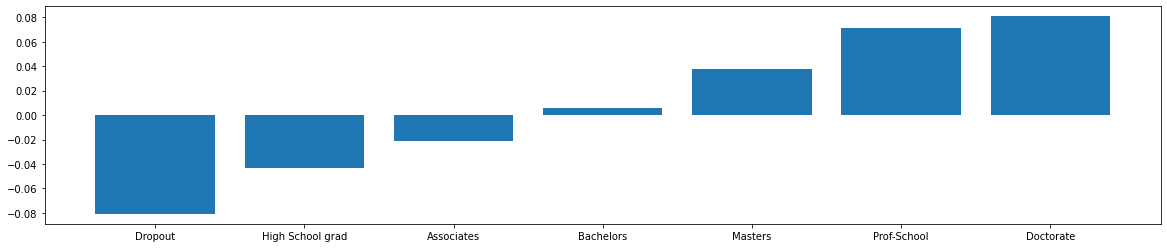

In [22]:
cat = 'Education'
idx = feature_names.index(cat)
plot_bar(cf.d_abs[idx], np.array(category_map[idx]), figsize=(20,4))

Explain instance:

In [23]:
explanation = cf.explain(X)

Helper function to more clearly describe explanations:

In [24]:
def describe_instance(X, explanation, eps=1e-2):
    print('Original instance: {}  -- proba: {}'.format(target_names[explanation.orig_class],
                                                       explanation.orig_proba[0]))
    print('Counterfactual instance: {}  -- proba: {}'.format(target_names[explanation.cf['class']],
                                                             explanation.cf['proba'][0]))
    print('\nCounterfactual perturbations...')
    print('\nCategorical:')
    X_orig_ord = ohe_to_ord(X, cat_vars_ohe)[0]
    X_cf_ord = ohe_to_ord(explanation.cf['X'], cat_vars_ohe)[0]
    delta_cat = {}
    for i, (_, v) in enumerate(category_map.items()):
        cat_orig = v[int(X_orig_ord[0, i])]
        cat_cf = v[int(X_cf_ord[0, i])]
        if cat_orig != cat_cf:
            delta_cat[feature_names[i]] = [cat_orig, cat_cf]
    if delta_cat:
        for k, v in delta_cat.items():
            print('{}: {}  -->   {}'.format(k, v[0], v[1]))
    print('\nNumerical:')
    delta_num = X_cf_ord[0, -4:] - X_orig_ord[0, -4:]
    n_keys = len(list(cat_vars_ord.keys()))
    for i in range(delta_num.shape[0]):
        if np.abs(delta_num[i]) > eps:
            print('{}: {:.2f}  -->   {:.2f}'.format(feature_names[i+n_keys],
                                            X_orig_ord[0,i+n_keys],
                                            X_cf_ord[0,i+n_keys]))

In [25]:
describe_instance(X, explanation)

Original instance: <=50K  -- proba: [0.70744723 0.29255277]
Counterfactual instance: >50K  -- proba: [0.37736374 0.62263626]

Counterfactual perturbations...

Categorical:
Education: Associates  -->   Bachelors

Numerical:


By obtaining a higher level of education the income is predicted to be above $50k.

## Change the categorical distance metric

Instead of `abdm`, we now use `mvdm` as our distance metric.

In [26]:
set_seed()
cf.fit(X_train, d_type='mvdm')
explanation = cf.explain(X)
describe_instance(X, explanation)

Original instance: <=50K  -- proba: [0.70744723 0.29255277]
Counterfactual instance: >50K  -- proba: [0.38161737 0.61838263]

Counterfactual perturbations...

Categorical:
Education: Associates  -->   Bachelors

Numerical:


The same conclusion hold using a different distance metric.

## Use k-d trees to build prototypes

We can also use *k-d trees* to build class prototypes to guide the counterfactual to nearby instances in the counterfactual class as described in [Interpretable Counterfactual Explanations Guided by Prototypes](https://arxiv.org/abs/1907.02584). 

In [27]:
use_kdtree = True
theta = 10.  # weight of prototype loss term

Initialize, fit and explain instance:

In [28]:
set_seed()
X = X_test[7].reshape((1,) + X_test[0].shape)
cf = CounterfactualProto(nn,
                         shape,
                         beta=beta,
                         theta=theta,
                         cat_vars=cat_vars_ohe,
                         ohe=True,
                         use_kdtree=use_kdtree,
                         max_iterations=max_iterations,
                         feature_range=feature_range,
                         c_init=c_init,
                         c_steps=c_steps
                        )
cf.fit(X_train, d_type='abdm')
explanation = cf.explain(X)
describe_instance(X, explanation)

Original instance: <=50K  -- proba: [0.5211548  0.47884512]
Counterfactual instance: >50K  -- proba: [0.49958408 0.500416  ]

Counterfactual perturbations...

Categorical:

Numerical:
Age: -0.53  -->   -0.51


By slightly increasing the age of the person the income would be predicted to be above $50k.

## Use an autoencoder to build prototypes

Another option is to use an autoencoder to guide the perturbed instance to the counterfactual class. We define and train the autoencoder:

In [29]:
def ae_model():
    # encoder
    x_in = Input(shape=(57,))
    x = Dense(60, activation='relu')(x_in)
    x = Dense(30, activation='relu')(x)
    x = Dense(15, activation='relu')(x)
    encoded = Dense(10, activation=None)(x)
    encoder = Model(x_in, encoded)
    
    # decoder
    dec_in = Input(shape=(10,))
    x = Dense(15, activation='relu')(dec_in)
    x = Dense(30, activation='relu')(x)
    x = Dense(60, activation='relu')(x)
    decoded = Dense(57, activation=None)(x)
    decoder = Model(dec_in, decoded)
    
    # autoencoder = encoder + decoder
    x_out = decoder(encoder(x_in))
    autoencoder = Model(x_in, x_out)
    autoencoder.compile(optimizer='adam', loss='mse')
    
    return autoencoder, encoder, decoder

In [30]:
set_seed()
ae, enc, dec = ae_model()
ae.summary()
ae.fit(X_train, X_train, batch_size=128, epochs=100, validation_data=(X_test, X_test), verbose=0)

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 57)]              0         
_________________________________________________________________
model_1 (Model)              (None, 10)                5935      
_________________________________________________________________
model_2 (Model)              (None, 57)                5982      
Total params: 11,917
Trainable params: 11,917
Non-trainable params: 0
_________________________________________________________________


Weights for the autoencoder and prototype loss terms:

In [31]:
beta = .1  # L1
gamma = 10.  # autoencoder
theta = .1  # prototype

Initialize, fit and explain instance:

In [32]:
set_seed()
X = X_test[19].reshape((1,) + X_test[0].shape)
cf = CounterfactualProto(nn,
                         shape,
                         beta=beta,
                         enc_model=enc,
                         ae_model=ae,
                         gamma=gamma,
                         theta=theta,
                         cat_vars=cat_vars_ohe,
                         ohe=True,
                         max_iterations=max_iterations,
                         feature_range=feature_range,
                         c_init=c_init,
                         c_steps=c_steps
                        )
cf.fit(X_train, d_type='abdm')
explanation = cf.explain(X)
describe_instance(X, explanation)

Original instance: >50K  -- proba: [0.48656026 0.5134398 ]
Counterfactual instance: <=50K  -- proba: [0.71456206 0.28543794]

Counterfactual perturbations...

Categorical:
Education: High School grad  -->   Dropout

Numerical:


## Black box model with k-d trees

Now we assume that we only have access to the model's prediction function and treat it as a black box. The k-d trees are again used to define the prototypes.

In [33]:
use_kdtree = True
theta = 10.  # weight of prototype loss term

Initialize, fit and explain instance:

In [34]:
set_seed()

X = X_test[24].reshape((1,) + X_test[0].shape)

# define predict function
predict_fn = lambda x: nn.predict(x)

cf = CounterfactualProto(predict_fn,
                         shape,
                         beta=beta,
                         theta=theta,
                         cat_vars=cat_vars_ohe,
                         ohe=True,
                         use_kdtree=use_kdtree,
                         max_iterations=max_iterations,
                         feature_range=feature_range,
                         c_init=c_init,
                         c_steps=c_steps
                        )
cf.fit(X_train, d_type='abdm')
explanation = cf.explain(X)
describe_instance(X, explanation)

Original instance: >50K  -- proba: [0.20676644 0.7932335 ]
Counterfactual instance: <=50K  -- proba: [0.5048416  0.49515834]

Counterfactual perturbations...

Categorical:

Numerical:
Age: -0.15  -->   -0.19
Hours per week: -0.20  -->   -0.51


If the person was younger and worked less, he or she would have a predicted income below $50k.